<a href="https://colab.research.google.com/github/RatchanonMo/curriculum/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.3 MB/s 
     |████████████████████████████████| 197 kB 42.9 MB/s 
     |████████████████████████████████| 1.2 MB 54.2 MB/s 
     |████████████████████████████████| 4.2 MB 56.3 MB/s 
     |████████████████████████████████| 346 kB 10.9 MB/s 
     |████████████████████████████████| 60 kB 9.6 MB/s 
     |████████████████████████████████| 140 kB 68.2 MB/s 
     |████████████████████████████████| 212 kB 75.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.0 MB/s 
     |████████████████████████████████| 86 kB 7.9 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
     |████████████████████████████████| 127 kB 77.5 MB/s 
     |████████████████████████████████| 144 kB 74.0 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 77.9 MB/s 
     |████████████████████████████████| 112 kB 49.9 MB/s 
     |█████████████████

In [9]:
from fastbook import *
import warnings
warnings.filterwarnings('ignore')

In [30]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [36]:
dls = fields.dataloaders("/content/gdrive/MyDrive/dataset/pre_model")

In [37]:
dls.vocab

['Black_rot', 'Downy_mildew', 'Healthy_leaf', 'Leaf_blight', 'Leaf_spot', 'Powdery_mildew', 'Rust_leaf', 'Sooty_mold', 'Tar_spot']

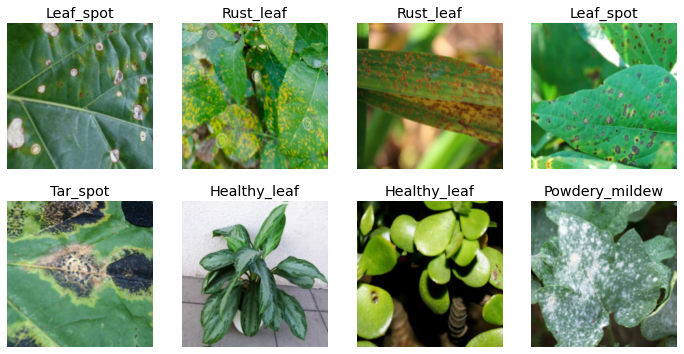

In [7]:
dls.train.show_batch(max_n=8, nrows=2)

In [20]:
learner = vision_learner(dls, models.vgg16_bn, metrics=[error_rate, accuracy], opt_func=Adam)

SuggestedLRs(valley=0.0014454397605732083)

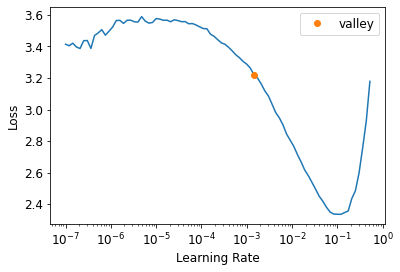

In [14]:
learner.lr_find() # หา learning rate ที่เหมาะสม

In [17]:
lr = learner.lr
lr

0.001

In [22]:
learner.fine_tune(epochs=100, freeze_epochs=1, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.010299,1.394330,0.283784,0.716216,00:20


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.016721,1.362752,0.277027,0.722973,00:21
1,0.014178,1.369839,0.283784,0.716216,00:22
2,0.015239,1.369238,0.297297,0.702703,00:21
3,0.014881,1.366085,0.290541,0.709459,00:21
4,0.013619,1.366446,0.283784,0.716216,00:21
5,0.012682,1.374544,0.290541,0.709459,00:21
6,0.011707,1.371851,0.297297,0.702703,00:21
7,0.012307,1.381473,0.283784,0.716216,00:21
8,0.012886,1.380342,0.277027,0.722973,00:21
9,0.012521,1.366447,0.277027,0.722973,00:21


KeyboardInterrupt: ignored

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.016721,1.362752,0.277027,0.722973,00:21
1,0.014178,1.369839,0.283784,0.716216,00:22
2,0.015239,1.369238,0.297297,0.702703,00:21
3,0.014881,1.366085,0.290541,0.709459,00:21
4,0.013619,1.366446,0.283784,0.716216,00:21
5,0.012682,1.374544,0.290541,0.709459,00:21
6,0.011707,1.371851,0.297297,0.702703,00:21
7,0.012307,1.381473,0.283784,0.716216,00:21
8,0.012886,1.380342,0.277027,0.722973,00:21
9,0.012521,1.366447,0.277027,0.722973,00:21


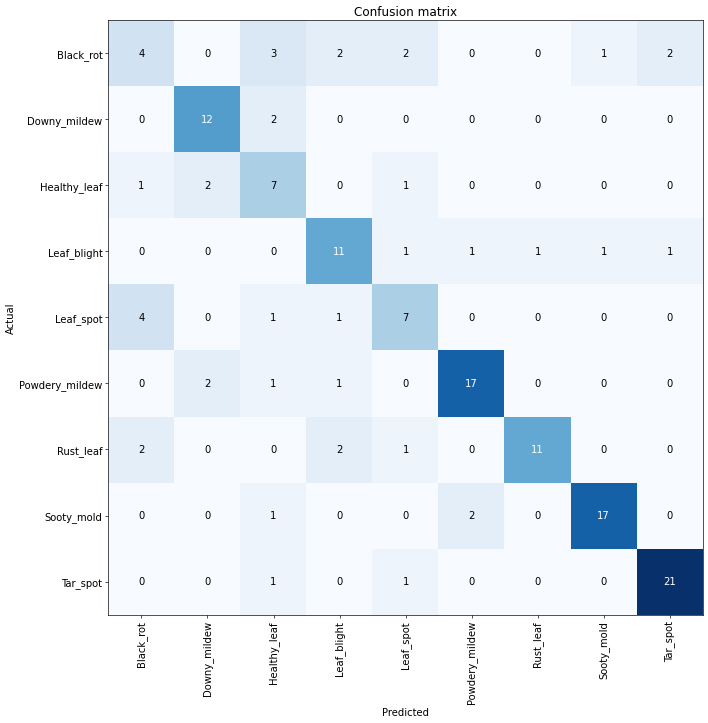

In [23]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.print_classification_report()

                precision    recall  f1-score   support

     Black_rot       0.36      0.29      0.32        14
  Downy_mildew       0.75      0.86      0.80        14
  Healthy_leaf       0.44      0.64      0.52        11
   Leaf_blight       0.65      0.69      0.67        16
     Leaf_spot       0.54      0.54      0.54        13
Powdery_mildew       0.85      0.81      0.83        21
     Rust_leaf       0.92      0.69      0.79        16
    Sooty_mold       0.89      0.85      0.87        20
      Tar_spot       0.88      0.91      0.89        23

      accuracy                           0.72       148
     macro avg       0.70      0.70      0.69       148
  weighted avg       0.73      0.72      0.72       148



In [25]:
interp.most_confused(min_val=5)

[]

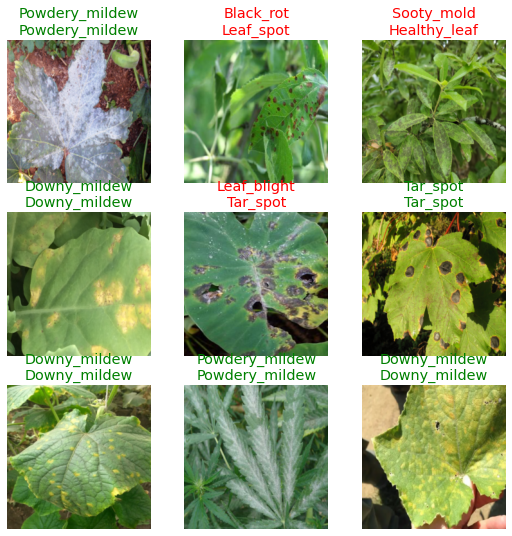

In [29]:
learner.show_results(shuffle=True)

## **เซฟโมเดล**

In [ ]:
%cd /content/gdrive/MyDrive/plant_diseases_classification/models
learner.export("dbc_resnet34_fastai.pkl")

/content/gdrive/MyDrive/plant_diseases_classification/models


# **โหลดโมเดลเพื่อทำนายผล**

In [ ]:
!pip install fastbook
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
  
learn_inf = load_learner('dbc_resnet34_fastai.pkl')

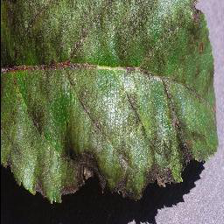

In [ ]:
Image.open("data/test/test/AppleScab3.JPG").resize((224, 224))

In [ ]:
learn_inf.predict("data/test/test/AppleScab3.JPG")

('Apple___Apple_scab',
 TensorBase(0),
 TensorBase([9.5804e-01, 2.1550e-05, 1.8836e-06, 6.6904e-06, 4.9031e-07, 7.5434e-08, 2.1115e-08, 2.3186e-02, 1.8522e-04, 2.2154e-06, 2.3831e-05, 4.9147e-08, 7.7756e-06, 3.0152e-04, 7.6980e-05, 5.8930e-08,
         2.4477e-07, 1.4005e-06, 3.1608e-07, 6.3702e-08, 1.4321e-04, 4.3028e-07, 4.7993e-08, 9.5368e-06, 6.5675e-07, 4.9231e-03, 1.9223e-04, 1.6223e-04, 3.4302e-08, 5.1736e-08, 5.3742e-07, 1.0029e-07,
         4.5847e-07, 2.7132e-09, 3.6704e-06, 3.5610e-09, 9.4946e-09, 1.2711e-02]))